In [1]:
# Cell 1: Import Libraries and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import joblib
from collections import Counter
import re
from wordcloud import WordCloud
# Text Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
# Metrics and Evaluation
from sklearn.metrics import (classification_report, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
# Data Balancing
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print("All libraries imported successfully!")


All libraries imported successfully!


In [2]:
# Cell 2: Load and Initial Data Exploration
# Load the dataset
df = pd.read_csv(r'D:\SPAM DETECTOR\spam (1).csv', encoding='latin-1')
print("Dataset Info:")
print(f"Shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
# Clean the dataset - keep only relevant columns
df = df[['v1', 'v2']].copy()
df.columns = ['label', 'message']
print(f"\nCleaned dataset shape: {df.shape}")
print("Label distribution:")
print(df['label'].value_counts())

Dataset Info:
Shape: (5572, 5)

Column names:
['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

First few rows:
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   U

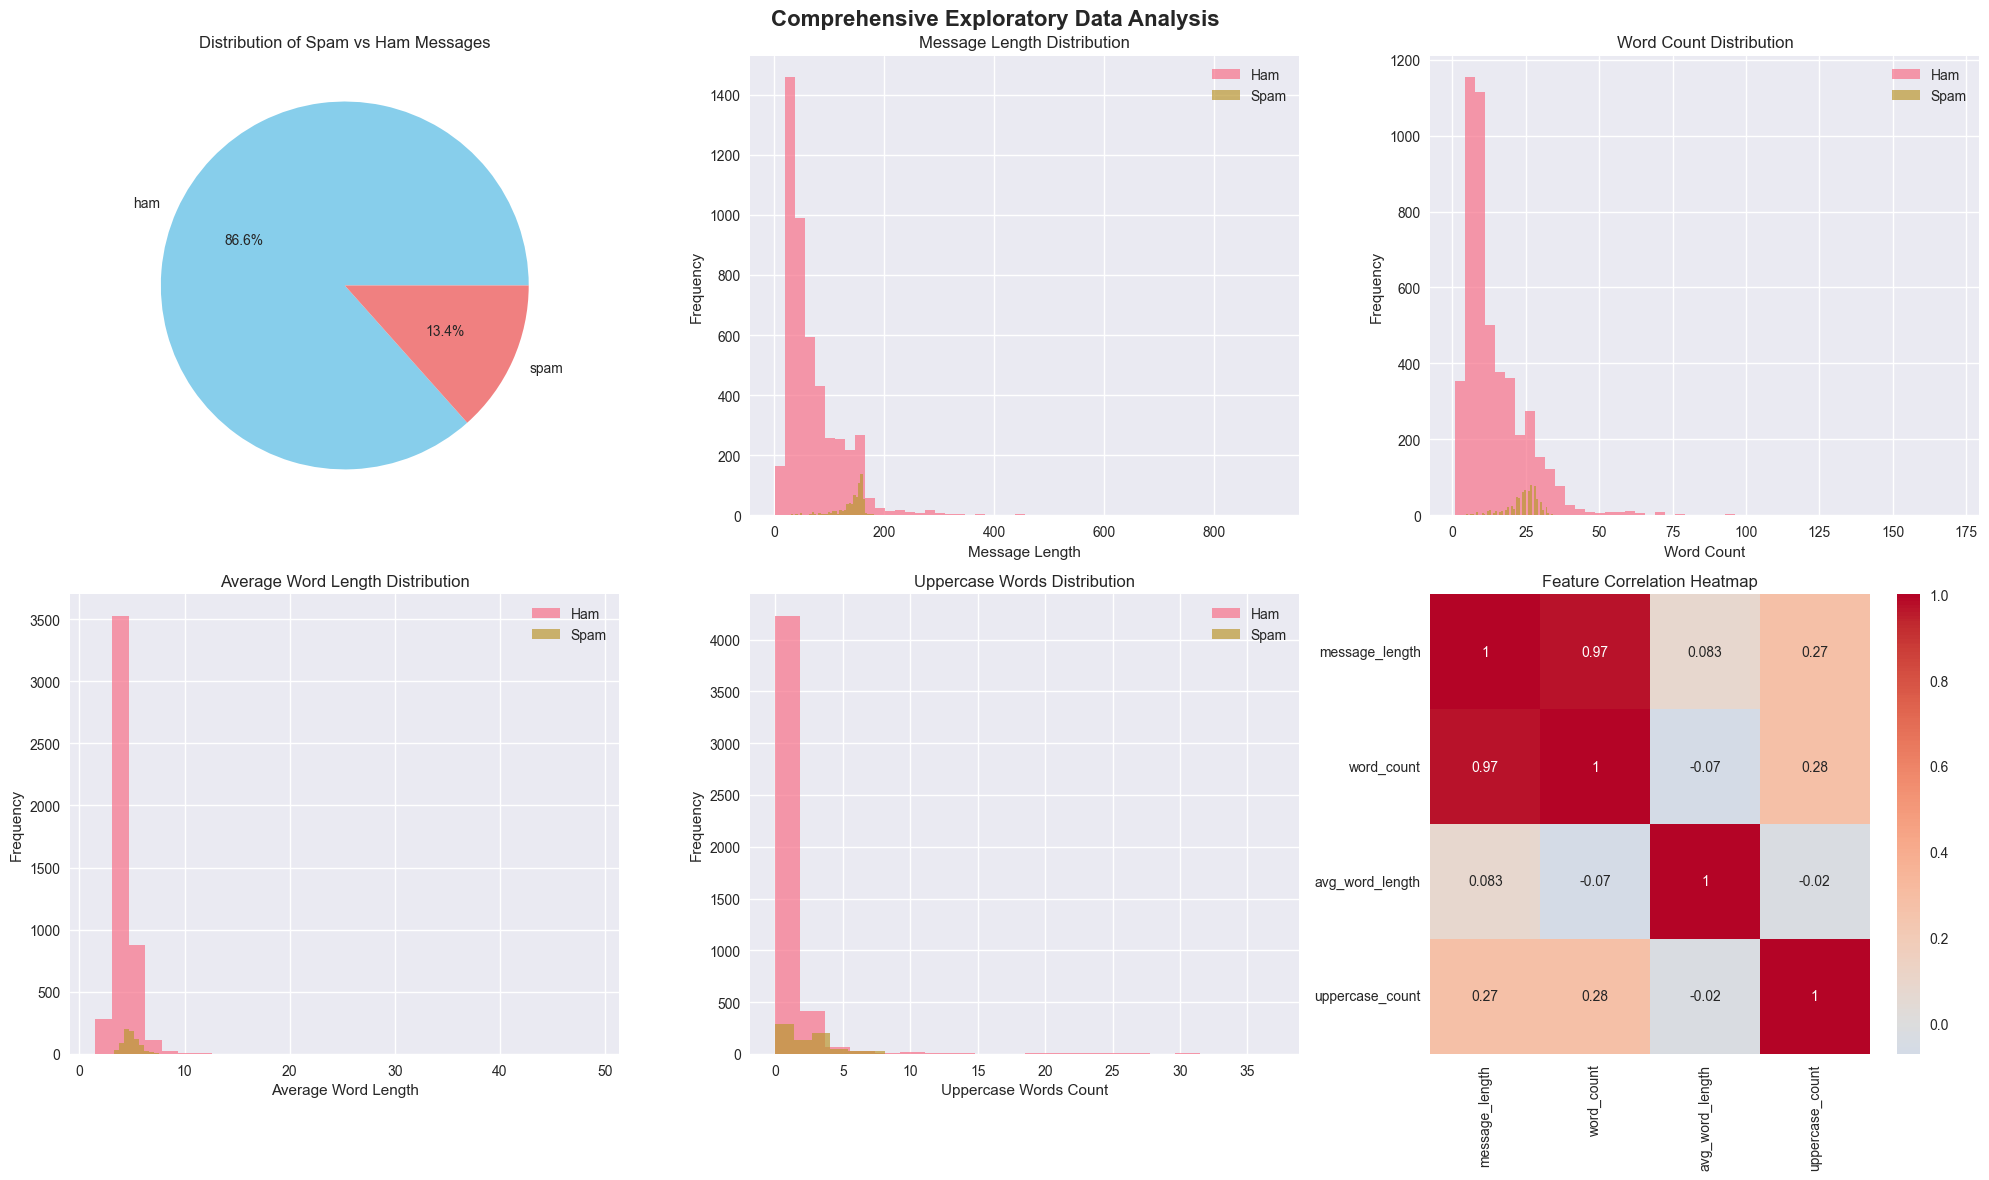


Statistical Summary by Label:
      message_length                                                           \
               count        mean        std   min    25%    50%    75%    max   
label                                                                           
ham           4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0   
spam           747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0   

      word_count             ... avg_word_length            uppercase_count  \
           count       mean  ...             75%        max           count   
label                        ...                                              
ham       4825.0  14.200622  ...           4.500  49.000000          4825.0   
spam       747.0  23.851406  ...           5.375  17.333333           747.0   

                                                     
           mean       std  min  25%  50%  75%   max  
label                                                
ham  

In [3]:
# Cell 3: Comprehensive EDA
# Create subplots for EDA
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Comprehensive Exploratory Data Analysis', fontsize=16, fontweight='bold')
# 1. Label Distribution
label_counts = df['label'].value_counts()
axes[0, 0].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', 
               colors=['skyblue', 'lightcoral'])
axes[0, 0].set_title('Distribution of Spam vs Ham Messages')

# 2. Message Length Distribution
df['message_length'] = df['message'].str.len()
df[df['label'] == 'ham']['message_length'].hist(alpha=0.7, label='Ham', bins=50, ax=axes[0, 1])
df[df['label'] == 'spam']['message_length'].hist(alpha=0.7, label='Spam', bins=50, ax=axes[0, 1])
axes[0, 1].set_xlabel('Message Length')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Message Length Distribution')
axes[0, 1].legend()

# 3. Word Count Distribution
df['word_count'] = df['message'].apply(lambda x: len(x.split()))
df[df['label'] == 'ham']['word_count'].hist(alpha=0.7, label='Ham', bins=50, ax=axes[0, 2])
df[df['label'] == 'spam']['word_count'].hist(alpha=0.7, label='Spam', bins=50, ax=axes[0, 2])
axes[0, 2].set_xlabel('Word Count')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Word Count Distribution')
axes[0, 2].legend()

# 4. Average Word Length
df['avg_word_length'] = df['message'].apply(lambda x: np.mean([len(word) for word in x.split()]))
df[df['label'] == 'ham']['avg_word_length'].hist(alpha=0.7, label='Ham', bins=30, ax=axes[1, 0])
df[df['label'] == 'spam']['avg_word_length'].hist(alpha=0.7, label='Spam', bins=30, ax=axes[1, 0])
axes[1, 0].set_xlabel('Average Word Length')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Average Word Length Distribution')
axes[1, 0].legend()

# 5. Number of uppercase words
df['uppercase_count'] = df['message'].apply(lambda x: len([word for word in x.split() if word.isupper()]))
df[df['label'] == 'ham']['uppercase_count'].hist(alpha=0.7, label='Ham', bins=20, ax=axes[1, 1])
df[df['label'] == 'spam']['uppercase_count'].hist(alpha=0.7, label='Spam', bins=20, ax=axes[1, 1])
axes[1, 1].set_xlabel('Uppercase Words Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Uppercase Words Distribution')
axes[1, 1].legend()

# 6. Correlation heatmap of numerical features
numeric_features = ['message_length', 'word_count', 'avg_word_length', 'uppercase_count']
correlation_matrix = df[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 2])
axes[1, 2].set_title('Feature Correlation Heatmap')

plt.tight_layout()
plt.show()

# Statistical summary
print("\nStatistical Summary by Label:")
print(df.groupby('label')[numeric_features].describe())


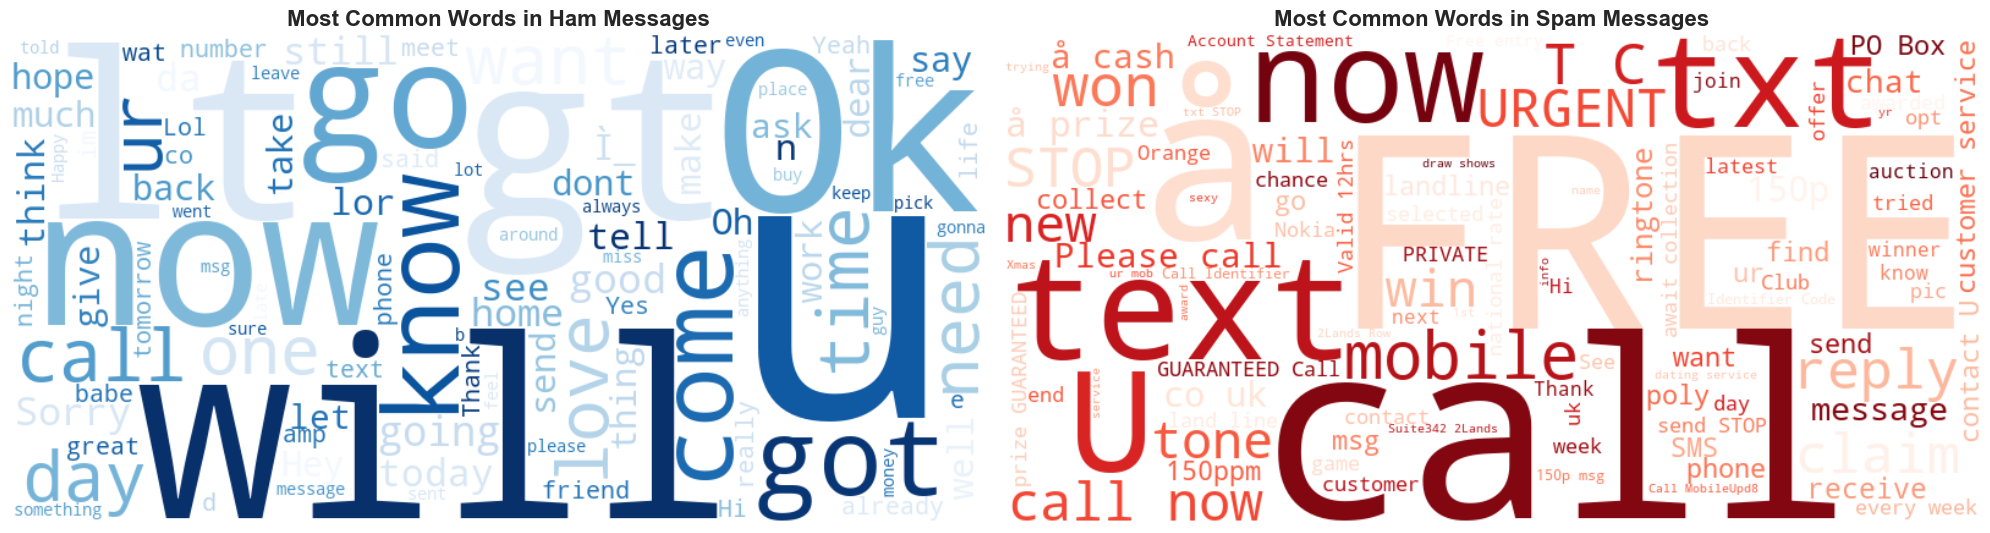

In [4]:
# Cell 4: Word Clouds for Visual Text Analysis
# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Ham messages word cloud
ham_text = ' '.join(df[df['label'] == 'ham']['message'])
ham_wordcloud = WordCloud(width=800, height=400, background_color='white', 
                         colormap='Blues', max_words=100).generate(ham_text)

axes[0].imshow(ham_wordcloud, interpolation='bilinear')
axes[0].set_title('Most Common Words in Ham Messages', fontsize=16, fontweight='bold')
axes[0].axis('off')

# Spam messages word cloud
spam_text = ' '.join(df[df['label'] == 'spam']['message'])
spam_wordcloud = WordCloud(width=800, height=400, background_color='white', 
                          colormap='Reds', max_words=100).generate(spam_text)

axes[1].imshow(spam_wordcloud, interpolation='bilinear')
axes[1].set_title('Most Common Words in Spam Messages', fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Cell 5: Advanced Text Preprocessing Class
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
    def clean_text(self, text):
        """Comprehensive text cleaning"""
        # Convert to lowercase
        text = text.lower()
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove phone numbers (basic pattern)
        text = re.sub(r'\b\d{10,11}\b', '', text)
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        # Remove extra whitespace and punctuation
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    def tokenize_and_lemmatize(self, text):
        """Tokenize and lemmatize text"""
        tokens = word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens 
                 if token not in self.stop_words and len(token) > 2]
        return ' '.join(tokens)
    def preprocess(self, text):
        """Complete preprocessing pipeline"""
        cleaned = self.clean_text(text)
        lemmatized = self.tokenize_and_lemmatize(cleaned)
        return lemmatized
# Apply preprocessing
preprocessor = TextPreprocessor()
print("Applying text preprocessing...")
df['text_cleaned'] = df['message'].apply(preprocessor.clean_text)
df['text_lemmatized'] = df['message'].apply(preprocessor.preprocess)
print("Preprocessing completed!")
print("\nExample of preprocessing:")
print(f"Original: {df['message'].iloc[0]}")
print(f"Cleaned: {df['text_cleaned'].iloc[0]}")
print(f"Lemmatized: {df['text_lemmatized'].iloc[0]}")

Applying text preprocessing...
Preprocessing completed!

Example of preprocessing:
Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Cleaned: go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
Lemmatized: jurong point crazy available bugis great world buffet cine got amore wat


In [7]:
# Cell 6: Advanced Feature Extraction Class
class FeatureExtractor:
    def __init__(self, max_features=5000):
        self.max_features = max_features
        self.count_vectorizer = CountVectorizer(max_features=max_features, ngram_range=(1, 2))
        self.tfidf_vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=(1, 2))
        self.word2vec_model = None
        self.scaler = StandardScaler()
    def fit_count_vectorizer(self, texts):
        """Fit count vectorizer"""
        return self.count_vectorizer.fit_transform(texts)
    def fit_tfidf_vectorizer(self, texts):
        """Fit TF-IDF vectorizer"""
        return self.tfidf_vectorizer.fit_transform(texts)
    def fit_word2vec(self, texts, vector_size=100, window=5, min_count=1, workers=4):
        """Fit Word2Vec model"""
        sentences = [text.split() for text in texts]
        self.word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, 
                                      min_count=min_count, workers=workers, seed=42)
        return self.get_word2vec_features(texts)
    def get_word2vec_features(self, texts):
        """Extract Word2Vec features"""
        if self.word2vec_model is None:
            raise ValueError("Word2Vec model not fitted yet")
        
        features = []
        for text in texts:
            words = text.split()
            word_vectors = []
            for word in words:
                if word in self.word2vec_model.wv:
                    word_vectors.append(self.word2vec_model.wv[word])
            
            if word_vectors:
                features.append(np.mean(word_vectors, axis=0))
            else:
                features.append(np.zeros(self.word2vec_model.vector_size))
        
        return np.array(features)
    
    def extract_all_features(self, texts):
        """Extract all types of features"""
        count_features = self.fit_count_vectorizer(texts)
        tfidf_features = self.fit_tfidf_vectorizer(texts)
        w2v_features = self.fit_word2vec(texts)
        return {
            'count': count_features,
            'tfidf': tfidf_features,
            'word2vec': w2v_features
        }
# Extract features
feature_extractor = FeatureExtractor(max_features=3000)
features = feature_extractor.extract_all_features(df['text_lemmatized'])
print(f"Count features shape: {features['count'].shape}")
print(f"TF-IDF features shape: {features['tfidf'].shape}")
print(f"Word2Vec features shape: {features['word2vec'].shape}")

Count features shape: (5572, 3000)
TF-IDF features shape: (5572, 3000)
Word2Vec features shape: (5572, 100)


Analyzing top features...


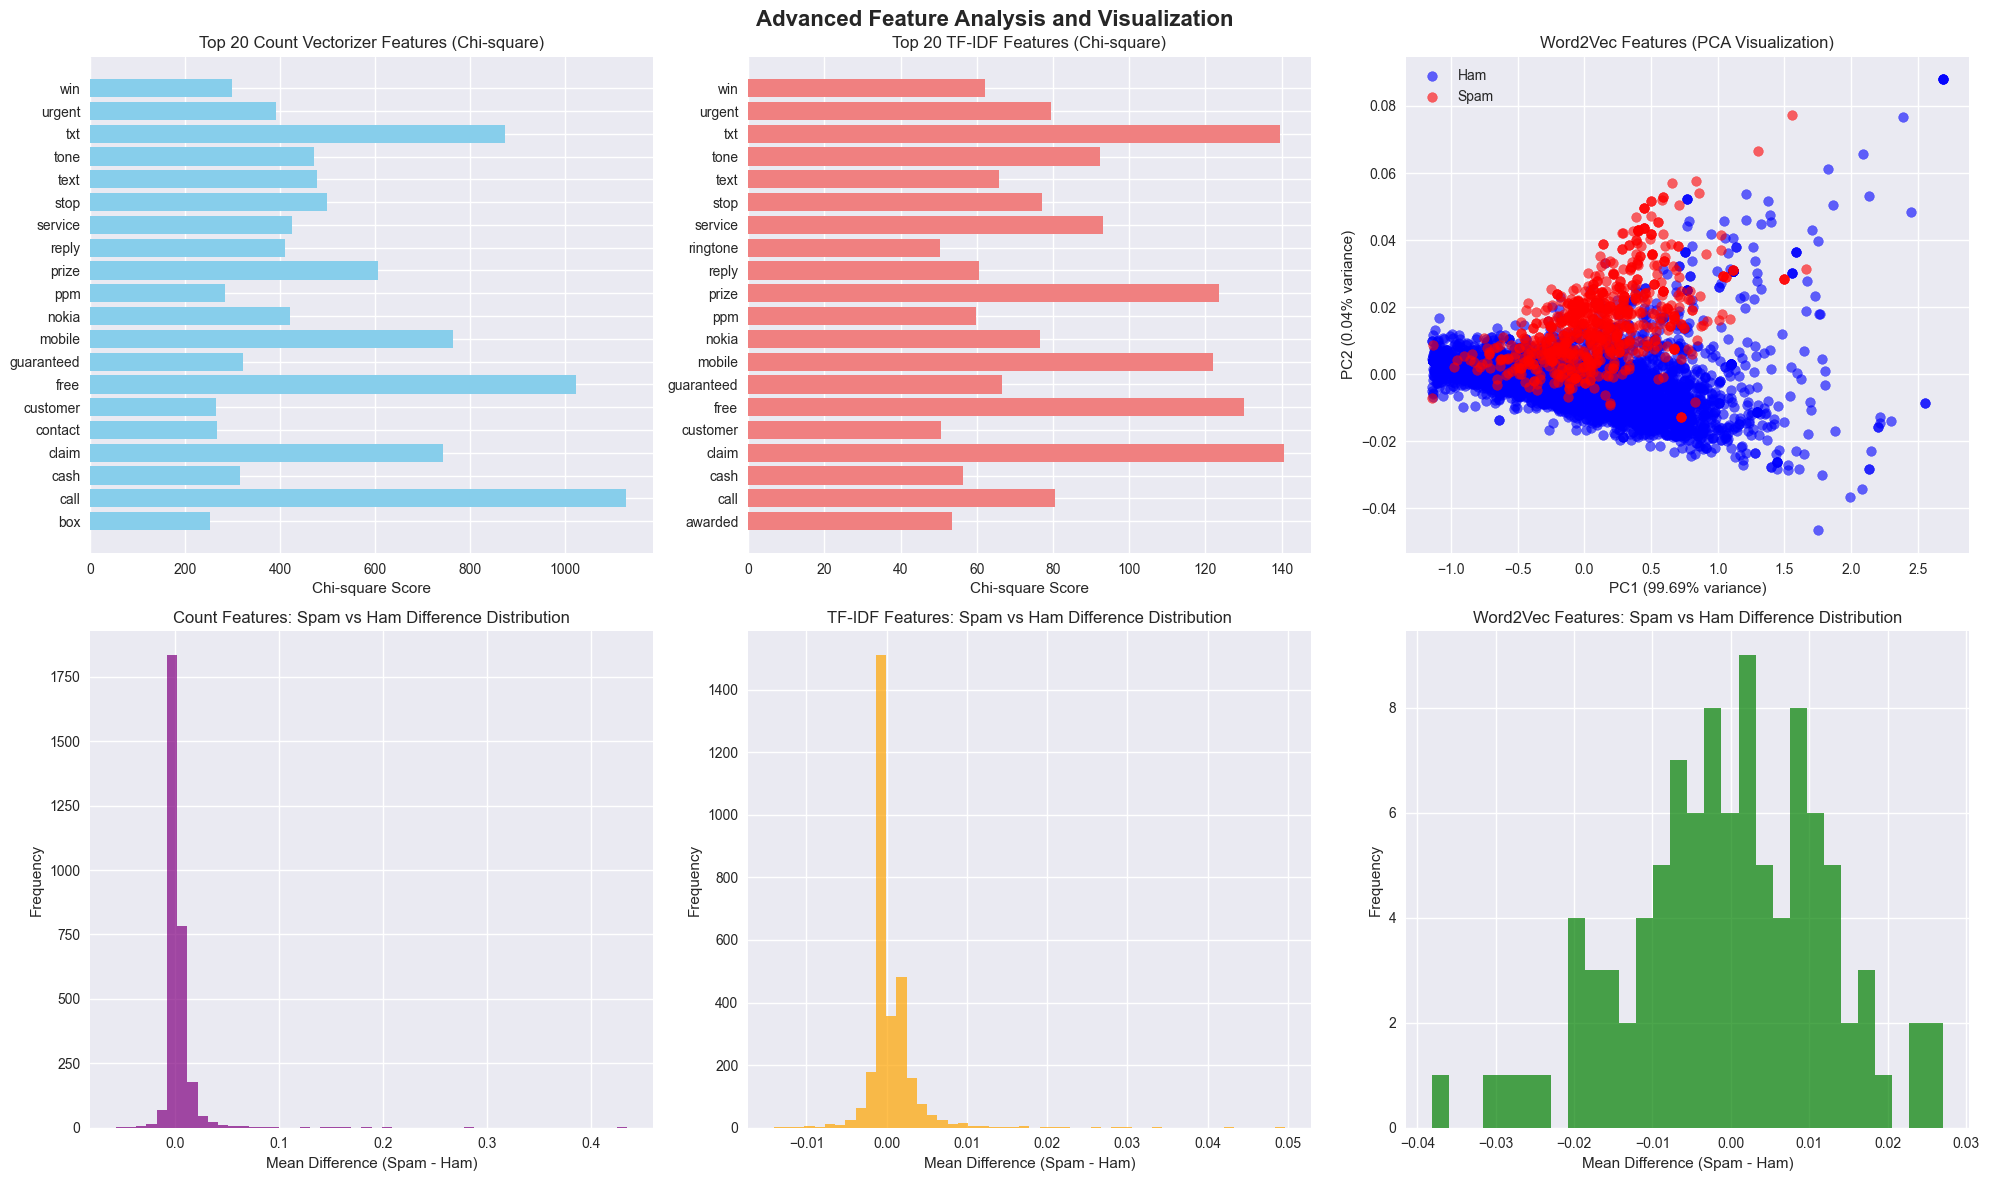


Word2Vec PCA explained variance ratio: [9.96914618e-01 4.17159676e-04]


In [8]:
# Cell 7: Feature Analysis and Visualization
# Top features analysis
def get_top_features(vectorizer, feature_matrix, labels, n_features=20):
    """Get top features using chi-square test"""
    selector = SelectKBest(chi2, k=n_features)
    selector.fit(feature_matrix, labels)
    feature_names = vectorizer.get_feature_names_out()
    top_indices = selector.get_support(indices=True)
    top_features = [feature_names[i] for i in top_indices]
    top_scores = selector.scores_[top_indices]
    
    return list(zip(top_features, top_scores))
# Convert labels to numeric
y = (df['label'] == 'spam').astype(int)
# Get top features
print("Analyzing top features...")
top_count_features = get_top_features(feature_extractor.count_vectorizer, features['count'], y)
top_tfidf_features = get_top_features(feature_extractor.tfidf_vectorizer, features['tfidf'], y)
# Visualization of features and analysis
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Advanced Feature Analysis and Visualization', fontsize=16, fontweight='bold')
# 1. Top Count Features
count_names, count_scores = zip(*top_count_features)
axes[0, 0].barh(range(len(count_names)), count_scores, color='skyblue')
axes[0, 0].set_yticks(range(len(count_names)))
axes[0, 0].set_yticklabels(count_names)
axes[0, 0].set_title('Top 20 Count Vectorizer Features (Chi-square)')
axes[0, 0].set_xlabel('Chi-square Score')
# 2. Top TF-IDF Features
tfidf_names, tfidf_scores = zip(*top_tfidf_features)
axes[0, 1].barh(range(len(tfidf_names)), tfidf_scores, color='lightcoral')
axes[0, 1].set_yticks(range(len(tfidf_names)))
axes[0, 1].set_yticklabels(tfidf_names)
axes[0, 1].set_title('Top 20 TF-IDF Features (Chi-square)')
axes[0, 1].set_xlabel('Chi-square Score')
# 3. Word2Vec PCA Visualization
pca = PCA(n_components=2, random_state=42)
w2v_pca = pca.fit_transform(features['word2vec'])
spam_mask = y == 1
ham_mask = y == 0
axes[0, 2].scatter(w2v_pca[ham_mask, 0], w2v_pca[ham_mask, 1], 
                  alpha=0.6, label='Ham', color='blue')
axes[0, 2].scatter(w2v_pca[spam_mask, 0], w2v_pca[spam_mask, 1], 
                  alpha=0.6, label='Spam', color='red')
axes[0, 2].set_title('Word2Vec Features (PCA Visualization)')
axes[0, 2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0, 2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[0, 2].legend()
# 4. Feature Distribution - Count
count_mean_spam = features['count'][spam_mask].mean(axis=0).A1
count_mean_ham = features['count'][ham_mask].mean(axis=0).A1
count_diff = count_mean_spam - count_mean_ham

axes[1, 0].hist(count_diff, bins=50, alpha=0.7, color='purple')
axes[1, 0].set_title('Count Features: Spam vs Ham Difference Distribution')
axes[1, 0].set_xlabel('Mean Difference (Spam - Ham)')
axes[1, 0].set_ylabel('Frequency')

# 5. Feature Distribution - TF-IDF
tfidf_mean_spam = features['tfidf'][spam_mask].mean(axis=0).A1
tfidf_mean_ham = features['tfidf'][ham_mask].mean(axis=0).A1
tfidf_diff = tfidf_mean_spam - tfidf_mean_ham

axes[1, 1].hist(tfidf_diff, bins=50, alpha=0.7, color='orange')
axes[1, 1].set_title('TF-IDF Features: Spam vs Ham Difference Distribution')
axes[1, 1].set_xlabel('Mean Difference (Spam - Ham)')
axes[1, 1].set_ylabel('Frequency')

# 6. Word2Vec Feature Distribution
w2v_mean_spam = features['word2vec'][spam_mask].mean(axis=0)
w2v_mean_ham = features['word2vec'][ham_mask].mean(axis=0)
w2v_diff = w2v_mean_spam - w2v_mean_ham

axes[1, 2].hist(w2v_diff, bins=30, alpha=0.7, color='green')
axes[1, 2].set_title('Word2Vec Features: Spam vs Ham Difference Distribution')
axes[1, 2].set_xlabel('Mean Difference (Spam - Ham)')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"\nWord2Vec PCA explained variance ratio: {pca.explained_variance_ratio_}")

In [9]:
# Cell 8: Data Balancing Analysis
print("Original class distribution:")
print(pd.Series(y).value_counts())
print(f"Class ratio (spam/total): {y.sum()/len(y):.3f}")
# Test different balancing techniques
balancing_techniques = {
    'None': None,
    'Random Over-sampling': RandomOverSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42),
    'Random Under-sampling': RandomUnderSampler(random_state=42),
    'SMOTE + Tomek': SMOTETomek(random_state=42)
}
# Compare balancing techniques using TF-IDF features (most suitable for text)
X_sample = features['tfidf']
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
    X_sample, y, test_size=0.3, random_state=42, stratify=y
)
balancing_results = {}
for name, technique in balancing_techniques.items():
    if technique is None:
        X_balanced, y_balanced = X_train_temp, y_train_temp
    else:
        if name == 'SMOTE' and hasattr(X_train_temp, 'toarray'):
            # SMOTE requires dense arrays
            X_balanced, y_balanced = technique.fit_resample(X_train_temp.toarray(), y_train_temp)
        elif name == 'SMOTE + Tomek' and hasattr(X_train_temp, 'toarray'):
            X_balanced, y_balanced = technique.fit_resample(X_train_temp.toarray(), y_train_temp)
        else:
            X_balanced, y_balanced = technique.fit_resample(X_train_temp, y_train_temp)
    # Quick evaluation with Logistic Regression
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_balanced, y_balanced)
    y_pred = lr.predict(X_test_temp)
    f1 = f1_score(y_test_temp, y_pred)
    balancing_results[name] = {
        'samples': len(y_balanced),
        'spam_ratio': y_balanced.sum() / len(y_balanced),
        'f1_score': f1
    }
print("\nBalancing Techniques Comparison:")
results_df = pd.DataFrame(balancing_results).T
print(results_df)
# Choose best balancing technique
best_technique_name = max(balancing_results.keys(), 
                         key=lambda x: balancing_results[x]['f1_score'])
best_technique = balancing_techniques[best_technique_name]
print(f"\nBest balancing technique: {best_technique_name}")

Original class distribution:
label
0    4825
1     747
Name: count, dtype: int64
Class ratio (spam/total): 0.134

Balancing Techniques Comparison:
                       samples  spam_ratio  f1_score
None                    3900.0    0.134103  0.821429
Random Over-sampling    6754.0    0.500000  0.907489
SMOTE                   6754.0    0.500000  0.887931
Random Under-sampling   1046.0    0.500000  0.859574
SMOTE + Tomek           6754.0    0.500000  0.887931

Best balancing technique: Random Over-sampling


In [10]:
# Cell 9: Prepare Final Dataset with Best Features
# Combine features for best performance
print("Preparing combined feature matrix...")
# Use TF-IDF as primary features (best for text classification)
X_primary = features['tfidf']
# Add selected Word2Vec features (use PCA to reduce dimensionality)
pca_w2v = PCA(n_components=50, random_state=42)
w2v_reduced = pca_w2v.fit_transform(features['word2vec'])
# Combine TF-IDF with reduced Word2Vec features
from scipy.sparse import hstack, csr_matrix
X_combined = hstack([X_primary, csr_matrix(w2v_reduced)])
print(f"Combined feature matrix shape: {X_combined.shape}")
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)
# Apply best balancing technique
if best_technique is not None:
    if best_technique_name in ['SMOTE', 'SMOTE + Tomek']:
        X_train_balanced, y_train_balanced = best_technique.fit_resample(
            X_train.toarray(), y_train
        )
        X_train_balanced = csr_matrix(X_train_balanced)
    else:
        X_train_balanced, y_train_balanced = best_technique.fit_resample(
            X_train, y_train
        )
else:
    X_train_balanced, y_train_balanced = X_train, y_train
print(f"Training set shape after balancing: {X_train_balanced.shape}")
print(f"Balanced class distribution: {pd.Series(y_train_balanced).value_counts()}")

Preparing combined feature matrix...
Combined feature matrix shape: (5572, 3050)
Training set shape after balancing: (7718, 3050)
Balanced class distribution: label
0    3859
1    3859
Name: count, dtype: int64


In [11]:
# Cell 10: Machine Learning Models Setup and Training
# Define models with optimal hyperparameters
models = {
    'Gaussian Naive Bayes': GaussianNB(),
    'Support Vector Machine': SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    'Logistic Regression': LogisticRegression(C=1.0, max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, min_samples_split=20, random_state=42)
}
# Training and evaluation
model_results = {}
trained_models = {}
print("Training and evaluating models...")
print("="*60)
for name, model in models.items():
    print(f"\nTraining {name}...")
    # Handle Gaussian NB separately (requires dense matrix)
    if name == 'Gaussian Naive Bayes':
        if hasattr(X_train_balanced, 'toarray'):
            X_train_dense = X_train_balanced.toarray()
            X_test_dense = X_test.toarray()
        else:
            X_train_dense = X_train_balanced
            X_test_dense = X_test
        
        model.fit(X_train_dense, y_train_balanced)
        y_pred = model.predict(X_test_dense)
        y_pred_proba = model.predict_proba(X_test_dense)[:, 1]
    else:
        model.fit(X_train_balanced, y_train_balanced)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    model_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc
    }
    trained_models[name] = model
    print(f" {name} completed - F1: {f1:.4f}, AUC: {auc:.4f}")
print("\n" + "="*60)
print("All models trained successfully!")

Training and evaluating models...

Training Gaussian Naive Bayes...
 Gaussian Naive Bayes completed - F1: 0.6521, AUC: 0.8834

Training Support Vector Machine...
 Support Vector Machine completed - F1: 0.9404, AUC: 0.9810

Training Random Forest...
 Random Forest completed - F1: 0.9066, AUC: 0.9820

Training Gradient Boosting...
 Gradient Boosting completed - F1: 0.8758, AUC: 0.9831

Training Logistic Regression...
 Logistic Regression completed - F1: 0.9195, AUC: 0.9865

Training Decision Tree...
 Decision Tree completed - F1: 0.8617, AUC: 0.9172

All models trained successfully!



Model Performance Comparison:
                        Accuracy  Precision  Recall  F1-Score  AUC-ROC
Gaussian Naive Bayes      0.8717     0.5115  0.8993    0.6521   0.8834
Support Vector Machine    0.9848     0.9853  0.8993    0.9404   0.9810
Random Forest             0.9758     0.9357  0.8792    0.9066   0.9820
Gradient Boosting         0.9659     0.8535  0.8993    0.8758   0.9831
Logistic Regression       0.9785     0.9195  0.9195    0.9195   0.9865
Decision Tree             0.9614     0.8272  0.8993    0.8617   0.9172

Best Model: Support Vector Machine
Best F1-Score: 0.9404


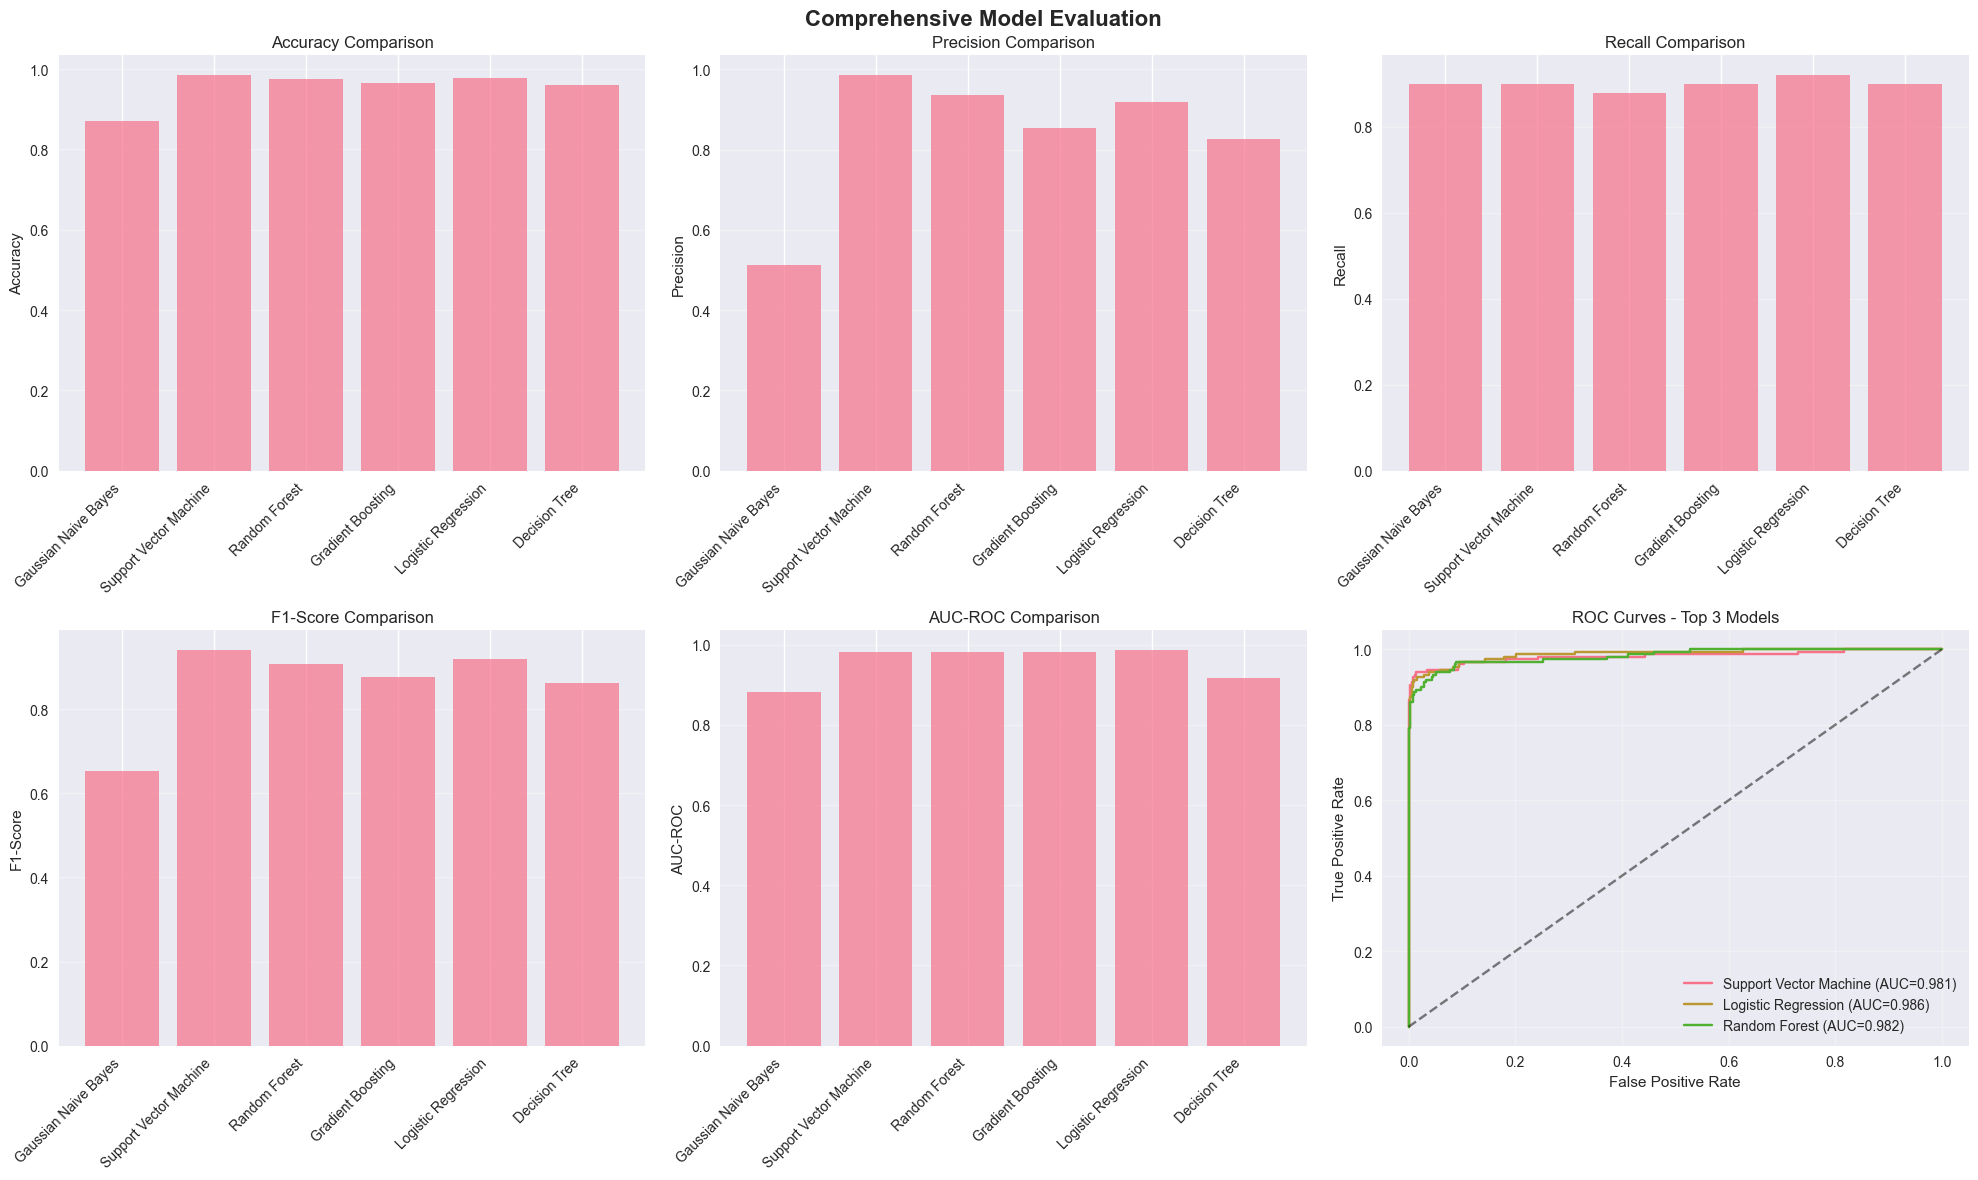


Detailed Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       966
        Spam       0.99      0.90      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115



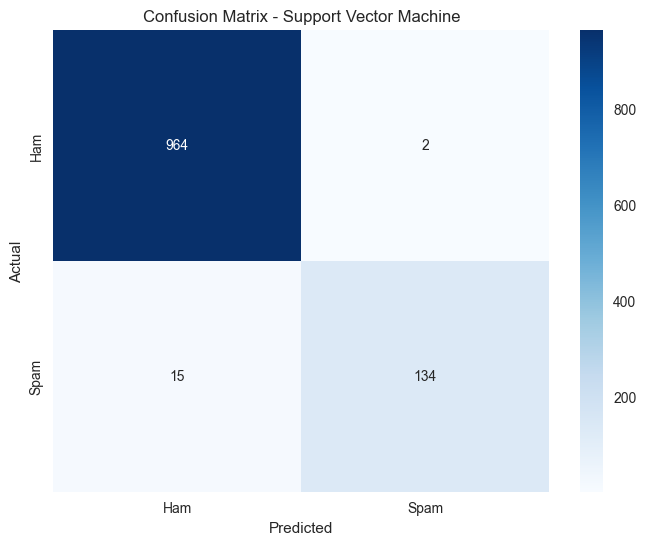

In [12]:
# Cell 11: Model Evaluation and Comparison
# Create comprehensive evaluation report
results_df = pd.DataFrame(model_results).T
results_df = results_df.round(4)
print("\nModel Performance Comparison:")
print("="*70)
print(results_df.to_string())
# Find best model
best_model_name = results_df['F1-Score'].idxmax()
best_model = trained_models[best_model_name]
print(f"\nBest Model: {best_model_name}")
print(f"Best F1-Score: {results_df.loc[best_model_name, 'F1-Score']:.4f}")
# Visualization of model performance
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Comprehensive Model Evaluation', fontsize=16, fontweight='bold')
# 1. Model Comparison - All Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
x_pos = np.arange(len(results_df.index))
for i, metric in enumerate(metrics):
    if i < 5:  # We have 5 metrics
        row = i // 3
        col = i % 3
        if row < 2 and col < 3:
            axes[row, col].bar(x_pos, results_df[metric], alpha=0.7)
            axes[row, col].set_title(f'{metric} Comparison')
            axes[row, col].set_ylabel(metric)
            axes[row, col].set_xticks(x_pos)
            axes[row, col].set_xticklabels(results_df.index, rotation=45, ha='right')
            axes[row, col].grid(axis='y', alpha=0.3)
# 2. ROC Curves for top 3 models
top_3_models = results_df.nlargest(3, 'F1-Score').index
axes[1, 2].set_title('ROC Curves - Top 3 Models')

for model_name in top_3_models:
    model = trained_models[model_name]
    
    if model_name == 'Gaussian Naive Bayes':
        y_pred_proba = model.predict_proba(X_test.toarray())[:, 1]
    else:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    axes[1, 2].plot(fpr, tpr, label=f'{model_name} (AUC={auc_score:.3f})')

axes[1, 2].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1, 2].set_xlabel('False Positive Rate')
axes[1, 2].set_ylabel('True Positive Rate')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed classification report for best model
print(f"\nDetailed Classification Report for {best_model_name}:")
print("="*60)

if best_model_name == 'Gaussian Naive Bayes':
    y_pred_best = best_model.predict(X_test.toarray())
else:
    y_pred_best = best_model.predict(X_test)

print(classification_report(y_test, y_pred_best, target_names=['Ham', 'Spam']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [13]:
# Cell 12: Ensemble Model Creation
print("Creating ensemble model...")
# Select top 3 models for ensemble
top_models = results_df.nlargest(3, 'F1-Score')
print(f"Top 3 models for ensemble: {list(top_models.index)}")
ensemble_models = []
for name in top_models.index:
    ensemble_models.append((name.lower().replace(' ', '_'), trained_models[name]))
# Create voting classifier
voting_classifier = VotingClassifier(
    estimators=ensemble_models,
    voting='soft'  # Use probability-based voting
)
print("Training ensemble model...")
voting_classifier.fit(X_train_balanced, y_train_balanced)
# Evaluate ensemble
y_pred_ensemble = voting_classifier.predict(X_test)
y_pred_proba_ensemble = voting_classifier.predict_proba(X_test)[:, 1]
ensemble_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_ensemble),
    'Precision': precision_score(y_test, y_pred_ensemble),
    'Recall': recall_score(y_test, y_pred_ensemble),
    'F1-Score': f1_score(y_test, y_pred_ensemble),
    'AUC-ROC': roc_auc_score(y_test, y_pred_proba_ensemble)
}
print(f"\nEnsemble Model Performance:")
for metric, score in ensemble_metrics.items():
    print(f"{metric}: {score:.4f}")
# Compare with best individual model
print(f"\nComparison with best individual model ({best_model_name}):")
print(f"Individual F1-Score: {results_df.loc[best_model_name, 'F1-Score']:.4f}")
print(f"Ensemble F1-Score: {ensemble_metrics['F1-Score']:.4f}")
print(f"Improvement: {ensemble_metrics['F1-Score'] - results_df.loc[best_model_name, 'F1-Score']:.4f}")


Creating ensemble model...
Top 3 models for ensemble: ['Support Vector Machine', 'Logistic Regression', 'Random Forest']
Training ensemble model...

Ensemble Model Performance:
Accuracy: 0.9839
Precision: 0.9781
Recall: 0.8993
F1-Score: 0.9371
AUC-ROC: 0.9906

Comparison with best individual model (Support Vector Machine):
Individual F1-Score: 0.9404
Ensemble F1-Score: 0.9371
Improvement: -0.0033


Performing cross-validation analysis...

Cross-validating Support Vector Machine...

Cross-validating Logistic Regression...

Cross-validating Random Forest...

Cross-Validation Results (5-fold):
                        accuracy_mean  accuracy_std  precision_mean  \
Support Vector Machine         0.9975        0.0009          0.9972   
Logistic Regression            0.9835        0.0024          0.9857   
Random Forest                  0.9501        0.0134          0.9859   

                        precision_std  recall_mean  recall_std  f1_mean  \
Support Vector Machine         0.0010       0.9979      0.0018   0.9975   
Logistic Regression            0.0048       0.9813      0.0063   0.9835   
Random Forest                  0.0045       0.9132      0.0240   0.9480   

                        f1_std  roc_auc_mean  roc_auc_std  
Support Vector Machine  0.0009        0.9989       0.0010  
Logistic Regression     0.0024        0.9979       0.0013  
Random Forest           0.0147        

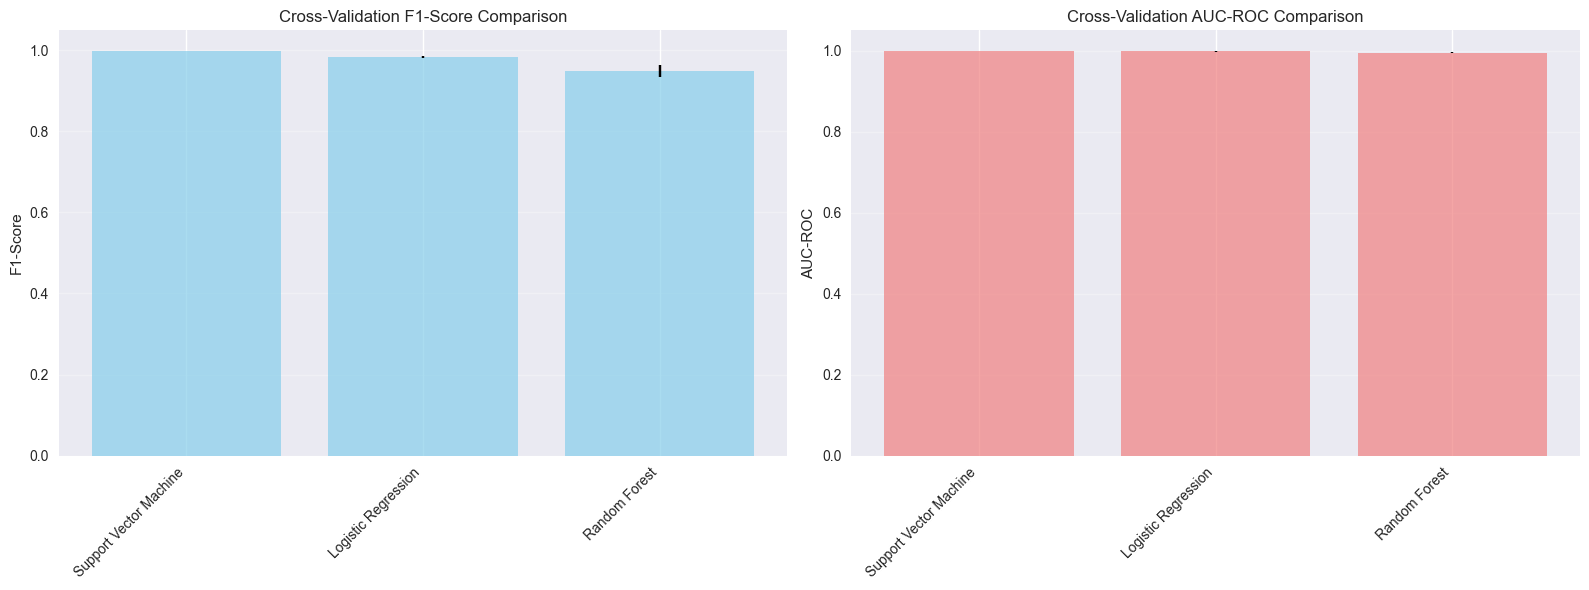

In [14]:
# Cell 13: Cross-Validation Analysis
print("Performing cross-validation analysis...")
# Cross-validation for top models
cv_results = {}
cv_scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
for name in top_models.index:
    model = trained_models[name]
    cv_results[name] = {}
    print(f"\nCross-validating {name}...")
    for score in cv_scores:
        if name == 'Gaussian Naive Bayes':
            # Use dense matrix for Gaussian NB
            cv_score = cross_val_score(model, X_train_balanced.toarray(), y_train_balanced, 
                                     cv=5, scoring=score, n_jobs=-1)
        else:
            cv_score = cross_val_score(model, X_train_balanced, y_train_balanced, 
                                     cv=5, scoring=score, n_jobs=-1)
        cv_results[name][score] = {
            'mean': cv_score.mean(),
            'std': cv_score.std()
        }
# Display cross-validation results
print("\nCross-Validation Results (5-fold):")
print("="*80)
cv_summary = {}
for model_name in cv_results.keys():
    cv_summary[model_name] = {}
    for score in cv_scores:
        mean_score = cv_results[model_name][score]['mean']
        std_score = cv_results[model_name][score]['std']
        cv_summary[model_name][f'{score}_mean'] = mean_score
        cv_summary[model_name][f'{score}_std'] = std_score

cv_df = pd.DataFrame(cv_summary).T
print(cv_df.round(4))

# Visualization of cross-validation results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CV F1-Score comparison
f1_means = [cv_results[name]['f1']['mean'] for name in cv_results.keys()]
f1_stds = [cv_results[name]['f1']['std'] for name in cv_results.keys()]

axes[0].bar(range(len(cv_results)), f1_means, yerr=f1_stds, 
           capsize=5, alpha=0.7, color='skyblue')
axes[0].set_title('Cross-Validation F1-Score Comparison')
axes[0].set_ylabel('F1-Score')
axes[0].set_xticks(range(len(cv_results)))
axes[0].set_xticklabels(cv_results.keys(), rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# CV AUC-ROC comparison
auc_means = [cv_results[name]['roc_auc']['mean'] for name in cv_results.keys()]
auc_stds = [cv_results[name]['roc_auc']['std'] for name in cv_results.keys()]

axes[1].bar(range(len(cv_results)), auc_means, yerr=auc_stds, 
           capsize=5, alpha=0.7, color='lightcoral')
axes[1].set_title('Cross-Validation AUC-ROC Comparison')
axes[1].set_ylabel('AUC-ROC')
axes[1].set_xticks(range(len(cv_results)))
axes[1].set_xticklabels(cv_results.keys(), rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# Cell 15: Model Pipeline Creation and Saving
print("Creating complete model pipeline...")
# Create a complete pipeline class
class SpamDetectionPipeline:
    def __init__(self, preprocessor, feature_extractor, pca_w2v, model, balancer=None):
        self.preprocessor = preprocessor
        self.feature_extractor = feature_extractor
        self.pca_w2v = pca_w2v
        self.model = model
        self.balancer = balancer
        
    def preprocess_text(self, text):
        """Preprocess single text"""
        return self.preprocessor.preprocess(text)
    
    def extract_features(self, texts):
        """Extract features from texts"""
        # Ensure texts is a list
        if isinstance(texts, str):
            texts = [texts]
        
        # Preprocess texts
        processed_texts = [self.preprocess_text(text) for text in texts]
        
        # Extract TF-IDF features
        tfidf_features = self.feature_extractor.tfidf_vectorizer.transform(processed_texts)
        
        # Extract Word2Vec features
        w2v_features = self.feature_extractor.get_word2vec_features(processed_texts)
        w2v_reduced = self.pca_w2v.transform(w2v_features)
        
        # Combine features
        combined_features = hstack([tfidf_features, csr_matrix(w2v_reduced)])
        
        return combined_features
    
    def predict(self, texts):
        """Predict spam/ham for texts"""
        features = self.extract_features(texts)
        
        if self.model.__class__.__name__ == 'GaussianNB':
            features = features.toarray()
        
        predictions = self.model.predict(features)
        return ['spam' if pred == 1 else 'ham' for pred in predictions]
    
    def predict_proba(self, texts):
        """Predict probabilities for texts"""
        features = self.extract_features(texts)
        
        if self.model.__class__.__name__ == 'GaussianNB':
            features = features.toarray()
        
        probabilities = self.model.predict_proba(features)
        return probabilities

# Create pipeline with best model
final_pipeline = SpamDetectionPipeline(
    preprocessor=preprocessor,
    feature_extractor=feature_extractor,
    pca_w2v=pca_w2v,
    model=best_model,
    balancer=best_technique
)

# Test the pipeline
test_messages = [
    "Congratulations! You've won $1000! Click here to claim your prize now!",
    "Hey, are we still meeting for lunch tomorrow?",
    "URGENT: Your account will be suspended. Click here immediately!",
    "Thanks for the birthday wishes yesterday, had a great time!"
]

print("Testing the pipeline with sample messages:")
print("="*60)

for i, message in enumerate(test_messages, 1):
    prediction = final_pipeline.predict([message])[0]
    probability = final_pipeline.predict_proba([message])[0]
    spam_prob = probability[1]
    
    print(f"\nMessage {i}: {message[:50]}...")
    print(f"Prediction: {prediction.upper()}")
    print(f"Spam Probability: {spam_prob:.4f}")

# Save the complete pipeline
print("\nSaving the model pipeline...")

pipeline_data = {
    'pipeline': final_pipeline,
    'model_name': best_model_name,
    'performance_metrics': model_results[best_model_name],
    'feature_names': {
        'tfidf': feature_extractor.tfidf_vectorizer.get_feature_names_out(),
        'tfidf_shape': features['tfidf'].shape,
        'w2v_shape': features['word2vec'].shape
    },
    'preprocessing_info': {
        'balancing_technique': best_technique_name,
        'training_samples': len(y_train_balanced),
        'test_samples': len(y_test)
    }
}

# Save using joblib (better for sklearn objects)
joblib.dump(pipeline_data, 'spam_detection_pipeline.pkl')
print("Pipeline saved as 'spam_detection_pipeline.pkl'")

# Also save individual components for flexibility
model_components = {
    'preprocessor': preprocessor,
    'feature_extractor': feature_extractor,
    'pca_w2v': pca_w2v,
    'best_model': best_model,
    'voting_classifier': voting_classifier,
    'model_performance': results_df
}

joblib.dump(model_components, 'spam_detection_components.pkl')
print("Individual components saved as 'spam_detection_components.pkl'")

Creating complete model pipeline...
Testing the pipeline with sample messages:

Message 1: Congratulations! You've won $1000! Click here to c...
Prediction: SPAM
Spam Probability: 0.9808

Message 2: Hey, are we still meeting for lunch tomorrow?...
Prediction: HAM
Spam Probability: 0.0000

Message 3: URGENT: Your account will be suspended. Click here...
Prediction: HAM
Spam Probability: 0.0543

Message 4: Thanks for the birthday wishes yesterday, had a gr...
Prediction: HAM
Spam Probability: 0.0007

Saving the model pipeline...
Pipeline saved as 'spam_detection_pipeline.pkl'
Individual components saved as 'spam_detection_components.pkl'


In [18]:
# Cell 16: Interactive User Prediction System
class InteractiveSpamDetector:
    def __init__(self, pipeline_path='spam_detection_pipeline.pkl'):
        """Load the saved pipeline"""
        try:
            self.pipeline_data = joblib.load(pipeline_path)
            self.pipeline = self.pipeline_data['pipeline']
            self.model_name = self.pipeline_data['model_name']
            self.performance_metrics = self.pipeline_data['performance_metrics']
            print(f"Loaded model: {self.model_name}")
            print(f"Model F1-Score: {self.performance_metrics['F1-Score']:.4f}")
        except FileNotFoundError:
            print("Error: Pipeline file not found. Please run the training cells first.")
            return
    def analyze_message(self, message):
        """Comprehensive analysis of a single message"""
        print("="*60)
        print("SPAM DETECTION ANALYSIS")
        print("="*60)
        
        print(f"Original Message: {message}")
        # Preprocess the message
        processed = self.pipeline.preprocess_text(message)
        print(f"Processed Message: {processed}")
        # Get prediction and probability
        prediction = self.pipeline.predict([message])[0]
        probabilities = self.pipeline.predict_proba([message])[0]
        ham_prob = probabilities[0]
        spam_prob = probabilities[1]
        print(f"\nPREDICTION: {prediction.upper()}")
        print(f"Confidence Scores:")
        print(f"  Ham: {ham_prob:.4f} ({ham_prob*100:.2f}%)")
        print(f"  Spam: {spam_prob:.4f} ({spam_prob*100:.2f}%)")
        # Risk assessment
        if spam_prob > 0.8:
            risk_level = "HIGH RISK"
        elif spam_prob > 0.5:
            risk_level = "MEDIUM RISK"
        else:
            risk_level = "LOW RISK"
        print(f"Risk Level: {risk_level}")
        # Message characteristics
        print(f"\nMessage Characteristics:")
        print(f"  Length: {len(message)} characters")
        print(f"  Word Count: {len(message.split())} words")
        print(f"  Uppercase Words: {len([w for w in message.split() if w.isupper()])}")
        print(f"  Contains Numbers: {'Yes' if any(c.isdigit() for c in message) else 'No'}")
        print(f"  Contains Special Chars: {'Yes' if any(c in '!@#$%^&*()' for c in message) else 'No'}")
        return {
            'prediction': prediction,
            'spam_probability': spam_prob,
            'ham_probability': ham_prob,
            'risk_level': risk_level
        }

# Initialize interactive detector
detector = InteractiveSpamDetector()
# Demo the interactive system
print("\n" + "="*60)
print("INTERACTIVE SPAM DETECTION DEMO")
print("="*60)
# Test with various message types
demo_messages = [
    "WINNER! You have been selected for a $5000 cash prize! Call now 1-800-CASH-NOW!",
    "Hey mom, just wanted to let you know I arrived safely at the hotel.",
]
# Analyze individual messages
print("\nIndividual Message Analysis:")
for i, msg in enumerate(demo_messages[:3], 1):
    print(f"\n{'='*40} MESSAGE {i} {'='*40}")
    detector.analyze_message(msg)


Loaded model: Support Vector Machine
Model F1-Score: 0.9404

INTERACTIVE SPAM DETECTION DEMO

Individual Message Analysis:

======================================== MESSAGE 1 ========================================
SPAM DETECTION ANALYSIS
Original Message: WINNER! You have been selected for a $5000 cash prize! Call now 1-800-CASH-NOW!
Processed Message: winner selected cash prize call cashnow

PREDICTION: SPAM
Confidence Scores:
  Ham: 0.1869 (18.69%)
  Spam: 0.8131 (81.31%)
Risk Level: HIGH RISK

Message Characteristics:
  Length: 79 characters
  Word Count: 13 words
  Uppercase Words: 2
  Contains Numbers: Yes
  Contains Special Chars: Yes

======================================== MESSAGE 2 ========================================
SPAM DETECTION ANALYSIS
Original Message: Hey mom, just wanted to let you know I arrived safely at the hotel.
Processed Message: hey mom wanted let know arrived safely hotel

PREDICTION: HAM
Confidence Scores:
  Ham: 0.9995 (99.95%)
  Spam: 0.0005 (0.05%)
